# Tangles-CNN Training Notebook

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB


In [2]:
# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models
from unet_wildcat import *

In [9]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
fold = "fold_HNL-29-18"
data_dir = "/home/pyushkevich/data/thon2019/exp01/%s" % (fold,)

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 30

# Input image size
input_size = 224

In [4]:
# Or use their initialization method
model=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.02, kmin=0.0, alpha=0.7, num_maps=4)
# model=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.05, kmin=0.02, alpha=0.5, num_maps=2)

In [5]:
# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [6]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [7]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], 2])
                labels_one_hot[:,0] = (labels==0)
                labels_one_hot[:,1] = (labels==1)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history




In [8]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=30)





Epoch 0/29
----------


/home/pyushkevich/miniconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


train Loss: 0.3763 Acc: 0.8700
val Loss: 0.2762 Acc: 0.9090

Epoch 1/29
----------
train Loss: 0.2923 Acc: 0.8998
val Loss: 0.2829 Acc: 0.9130

Epoch 2/29
----------
train Loss: 0.2791 Acc: 0.9038
val Loss: 0.2483 Acc: 0.9205

Epoch 3/29
----------
train Loss: 0.2503 Acc: 0.9083
val Loss: 0.1920 Acc: 0.9400

Epoch 4/29
----------
train Loss: 0.2437 Acc: 0.9150
val Loss: 0.2253 Acc: 0.9230

Epoch 5/29
----------
train Loss: 0.2453 Acc: 0.9123
val Loss: 0.1723 Acc: 0.9460

Epoch 6/29
----------
train Loss: 0.2401 Acc: 0.9130
val Loss: 0.1783 Acc: 0.9460

Epoch 7/29
----------
train Loss: 0.2225 Acc: 0.9160
val Loss: 0.1743 Acc: 0.9490

Epoch 8/29
----------
train Loss: 0.2342 Acc: 0.9125
val Loss: 0.1636 Acc: 0.9510

Epoch 9/29
----------
train Loss: 0.2189 Acc: 0.9198
val Loss: 0.1652 Acc: 0.9550

Epoch 10/29
----------
train Loss: 0.2212 Acc: 0.9178
val Loss: 0.1925 Acc: 0.9460

Epoch 11/29
----------
train Loss: 0.2120 Acc: 0.9287
val Loss: 0.1424 Acc: 0.9570

Epoch 12/29
----------
t

In [10]:
model_dir="/home/pyushkevich/resnet/thon2019/exp01/%s" % (fold,)
os.makedirs(model_dir)
torch.save(model_ft.state_dict(),os.path.join(model_dir, "my_wildcat_50_30epoch_k02_upsample.dat"))

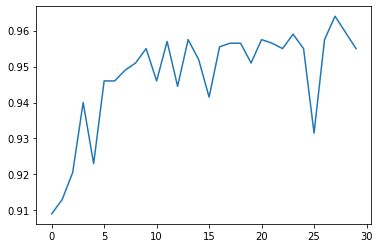

In [11]:
plt.plot(hist)

In [12]:
del model_ft
torch.cuda.empty_cache()

In [14]:
!nvidia-smi

Wed Oct  2 02:05:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |   6606MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  